In [44]:
%reload_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Number of batches of 32 images train_ds: 250
Number of batches of 32 images validation_ds: 32
Number of batches of 32 images test_ds: 32


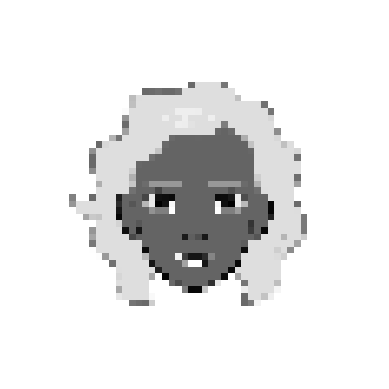

In [45]:
%run "../generacion_cartoon/data/0.1-drac-make_dataset.ipynb"
import generacion_cartoon.utils.paths as path
import notebooks.drac_CNVAE_gradient as CNVAE
import generacion_cartoon.visualization.visualize_CNVAE as visualize 
import tensorflow as tf
import time
import numpy as np

In [46]:
print("GPUs available:", len(tf.config.list_physical_devices('GPU')))

GPUs available: 1


In [47]:
import mlflow
import dagshub

In [78]:
params ={'latent_dim':2,
 'epochs':30,
 'epsilon':1e-3,
 'alpha':1.0, #reconstruction_loss
 'beta':1.0,  #grad_decoded_loss
 'gamma':1.0} #center_loss

model = CNVAE.CNVAE(latent_dim=params['latent_dim'], alpha=params['alpha'],beta=params['beta'],gamma=params['gamma'])

In [79]:
name_model = f'model_NL_CNVAE__epochs={params["epochs"]}_epsilon{params["epsilon"]}_alpha={params["alpha"]}_beta{params["beta"]}_gamma{params["gamma"]}.weights.h5'
path_models = path.models_dir(name_model)

In [ ]:
dagshub.init(repo_owner='DRACDARKTIME', repo_name='VA_cartoon', mlflow=True)
mlflow.set_experiment("LossFuntion_CNVAE_alpha_beta_gamma")
mlflow.start_run()
mlflow.log_params(params)

tf.config.run_functions_eagerly(True)
visualize.plot_latent_images(model=model, num_images_x=20, epoch=0)

optimizer = tf.keras.optimizers.Adam(params['epsilon'])
best_total_loss = 100000
count = 0
patience = 10
for epoch in range(1, params['epochs'] + 1):
    start_time = time.time()

    for idx, train_x in enumerate(train_ds):
        model.train_step(train_x, optimizer)

        if epoch == 1 and idx % 75 == 0:
            visualize.plot_latent_images(model=model,
            num_images_x=20,
            epoch=epoch,
            first_epoch=True,
            f_ep_count=idx)      

    end_time = time.time()
    loss = tf.keras.metrics.Mean()
    loss1 = tf.keras.metrics.Mean()
    loss2 = tf.keras.metrics.Mean()
    loss3 = tf.keras.metrics.Mean()
    for test_x in test_ds:
        total_loss, reconstruction_loss, center_loss, grad_decoded_loss =model.compute_loss(test_x)
        loss(total_loss)
        loss1(reconstruction_loss)
        loss2(center_loss)
        loss3(grad_decoded_loss)
    total_loss = loss.result()
    reconstruction_loss = loss1.result()
    center_loss = loss2.result()
    grad_decoded_loss = loss3.result()
    if total_loss < best_total_loss:
        best_total_loss = total_loss
        model.save_weights(path_models)
        print('Best model saved with best ELBO: {:.2f}'.format(total_loss))
        count=0
    else:
        count = count + 1
    mlflow.log_metric('total_loss_test', total_loss, step = epoch)
    mlflow.log_metric('reconstruction_loss', reconstruction_loss, step = epoch)
    mlflow.log_metric('center_loss', center_loss, step = epoch)
    mlflow.log_metric('grad_decodad_loss', grad_decoded_loss, step = epoch)
    print('Epoch: {}, Test set total_loss: {:.2f}, reconstruction_loss: {:.2f}, grad_decoded_loss: {:.2f},center_loss: {:.2f}, time_epoch: {:.2f}'
        .format(epoch, total_loss,reconstruction_loss,grad_decoded_loss,center_loss, end_time - start_time))
    if epoch != 1:
        visualize.plot_latent_images(model=model, num_images_x= 20, epoch=epoch)
    if count == patience:
        break
#mlflow.tensorflow.log_model(model, 'model')        
mlflow.end_run()
name_gif = f'grid_CNVAE_epochs={params["epochs"]}_epsilon{params["epsilon"]}_alpha={params["alpha"]}_beta{params["beta"]}_gamma{params["gamma"]}.gif'
visualize.create_gif(name_gif=name_gif, path_save_gif=path.data_created_dir('cnvae'))

In [83]:

mlflow.end_run()

2024/10/25 07:44:21 INFO mlflow.tracking._tracking_service.client: 🏃 View run persistent-ape-769 at: https://dagshub.com/DRACDARKTIME/VA_cartoon.mlflow/#/experiments/2/runs/91d53e357ed74429b72df85cbb39e26a.
2024/10/25 07:44:21 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/DRACDARKTIME/VA_cartoon.mlflow/#/experiments/2.


In [72]:
model.load_weights(path_models)

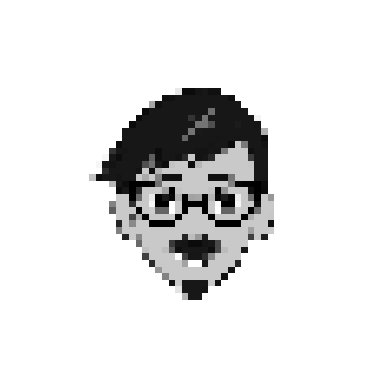

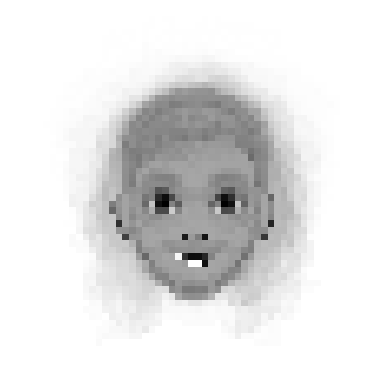

In [75]:
visualize.plot_img_original_generated(model=model,num_img=10,test_ds=test_ds)

In [74]:
visualize.plot_latent_images(model=model, num_images_x= 20, epoch=2, stan_des= 1, mean=0.02)